### Import packages

In [1]:
# import Gavin.utils.make_network as mn
# from time import time
# import pandas as pd
# import oatpy as oat
# from scipy.optimize import linear_sum_assignment
# from sklearn.metrics import jaccard_score
# import csv
# from sklearn.cluster import SpectralClustering
# from mpl_toolkits.mplot3d import Axes3D
# import plotly.express as px
# import pebble
import plotly.graph_objects as go
import networkx as nx
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
import pprint
from collections import Counter
import seaborn as sns
import plotly.graph_objs as go
import pickle
from networkx.algorithms.community.quality import modularity

### Load network from pickle

In [4]:
fp = "INSERT FILE PATH HERE"
with open(f"{fp}/2024SummerTopo/Frances/applied_math_grb_64hr_12pr.pickle", "rb") as file:
    res = pickle.load(file)
pickle_res1 = res

In [5]:
G = pickle_res1["graph"]

### Plot lengths of cycles

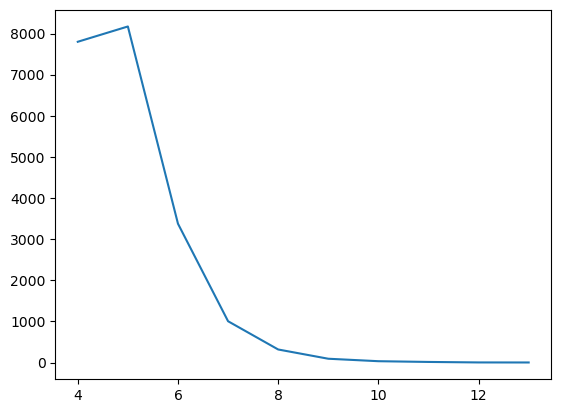

In [6]:
v, c = np.unique(pickle_res1['optimized']['optimal cycle nnz'].dropna(), return_counts=True)

plt.plot(v, c)

In [ ]:
big_rep_cycle_list1 = []
for thing in (pickle_res1['optimized']["optimal cycle nodes"].dropna()):
    big_rep_cycle_list1.append(list(thing))

### Get community clusters

In [ ]:
coms = nx.community.louvain_communities(G, seed=12, resolution=2.2)
len(coms)

41

Repeat process 100 times to check for stability

In [ ]:
lens=[]
all_communities_list = []
for i in range(100):
    coms = nx.community.louvain_communities(G, seed=i, resolution=2.2)
    all_communities_list.append(coms)
    lens.append(len(coms))
print(f"average: {np.mean(lens)}")
print(f"std: {np.std(lens, ddof=1)}")


average: 40.54
std: 1.5137084036607351


In [ ]:
def flatten_communities(communities):
    node_to_community = {}
    for i, community in enumerate(communities):
        for node in community:
            node_to_community[node] = i
    return [node_to_community[node] for node in G.nodes()]
flattened_communities = [flatten_communities(communities) for communities in all_communities_list]

ari_scores = []  # adjusted random info score
nmi_scores = []  # normalized mutual info score

for i in range(100):
    for j in range(i + 1, 100):
        ari = adjusted_rand_score(flattened_communities[i], flattened_communities[j])  # compare communities pairwise
        nmi = normalized_mutual_info_score(flattened_communities[i], flattened_communities[j])
        ari_scores.append(ari)
        nmi_scores.append(nmi)

In [ ]:
ari_mean = np.mean(ari_scores)
ari_std = np.std(ari_scores)

nmi_mean = np.mean(nmi_scores)
nmi_std = np.std(nmi_scores)

print(f"ARI Mean: {ari_mean}, ARI Std: {ari_std}")
print(f"NMI Mean: {nmi_mean}, NMI Std: {nmi_std}")

ARI Mean: 0.6472748652368143, ARI Std: 0.033587126179602717
NMI Mean: 0.679504733901672, NMI Std: 0.01915554333916772


ARI: -1 to 1. 1 is perfect agreement. 0 is random labeling. -1 is worse than random.
NMI: 0 to 1. 1 is perfect agreement. 0 is no agreement.

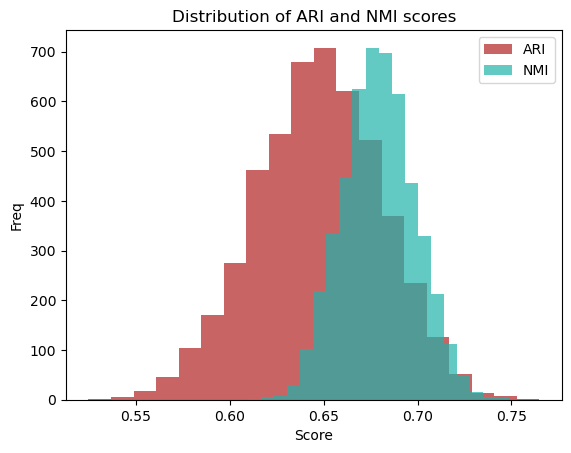

In [ ]:
plt.hist(ari_scores, bins=20, alpha=0.7, label='ARI', color="firebrick")
plt.hist(nmi_scores, bins=20, alpha=0.7, label='NMI', color="lightseagreen")
plt.xlabel('Score')
plt.ylabel('Freq')
plt.legend(loc='best')
plt.title('Distribution of ARI and NMI scores')
plt.show()

## Repeat process for different resolutions

In [ ]:
nmi_means = []
ari_means = []
resolutions = []
community_sizes = []
modularities = []

for reso in range(10,50,2):  # test resolutions between 1 and 4.8 inclusive, going by .2
    res = reso/10
    resolutions.append(res)
    all_communities_list = []
    lens = []
    mods = []
    for i in range(10):
        coms = nx.community.louvain_communities(G, seed=i, resolution=res)
        mods.append(modularity(G, coms, resolution=res))
        all_communities_list.append(coms)
        lens.append(len(coms))
    print(f"resolution: {res}")
    print(f"average communities: {np.mean(lens)}, std: {np.std(lens, ddof=1)}")
    community_sizes.append(np.mean(lens))
    modularities.append(np.mean(mods))

    def flatten_communities(communities):
        node_to_community = {}
        for i, community in enumerate(communities):
            for node in community:
                node_to_community[node] = i
        return [node_to_community[node] for node in G.nodes()]
    flattened_communities = [flatten_communities(communities) for communities in all_communities_list]

    ari_scores = []
    nmi_scores = []

    for i in range(10):
        for j in range(i + 1, 10):
            ari = adjusted_rand_score(flattened_communities[i], flattened_communities[j])
            nmi = normalized_mutual_info_score(flattened_communities[i], flattened_communities[j])
            ari_scores.append(ari)
            nmi_scores.append(nmi)

    ari_mean = np.mean(ari_scores)
    ari_std = np.std(ari_scores)
    ari_means.append(ari_mean)

    nmi_mean = np.mean(nmi_scores)
    nmi_std = np.std(nmi_scores)
    nmi_means.append(nmi_mean)

    print(f"ARI mean: {ari_mean}, ARI std: {ari_std}")
    print(f"NMI mean: {nmi_mean}, NMI std: {nmi_std}")

resolution: 1.0
average communities: 17.5, std: 0.7071067811865476
ARI mean: 0.637436435608473, ARI std: 0.05881790945857058
NMI mean: 0.6717346982462893, NMI std: 0.04076593920258993
resolution: 1.2
average communities: 19.8, std: 0.9189365834726815
ARI mean: 0.6566194647449987, ARI std: 0.06244453504057961
NMI mean: 0.6883247041822966, NMI std: 0.035019873742237556
resolution: 1.4
average communities: 24.2, std: 1.2292725943057183
ARI mean: 0.588111468776141, ARI std: 0.03702881676533706
NMI mean: 0.6609665817082434, NMI std: 0.0230339383042161
resolution: 1.6
average communities: 28.0, std: 1.4907119849998598
ARI mean: 0.6232326895518792, ARI std: 0.04089812176125969
NMI mean: 0.6721659083735958, NMI std: 0.022786966327910968
resolution: 1.8
average communities: 32.2, std: 1.3165611772087666
ARI mean: 0.6549358394770575, ARI std: 0.03147502017374749
NMI mean: 0.6850738753502058, NMI std: 0.0166673531362169
resolution: 2.0
average communities: 36.2, std: 1.0327955589886444
ARI mean: 

In [ ]:
real_resolutions = resolutions
real_community_sizes = community_sizes

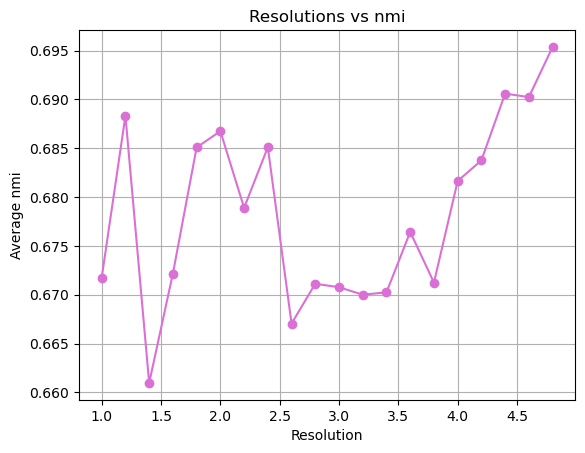

In [ ]:
plt.plot(resolutions, nmi_means, marker='o', color = "orchid")
plt.xlabel('Resolution')
plt.ylabel('Average nmi')
plt.title('Resolutions vs nmi')
plt.grid(True)
plt.show()

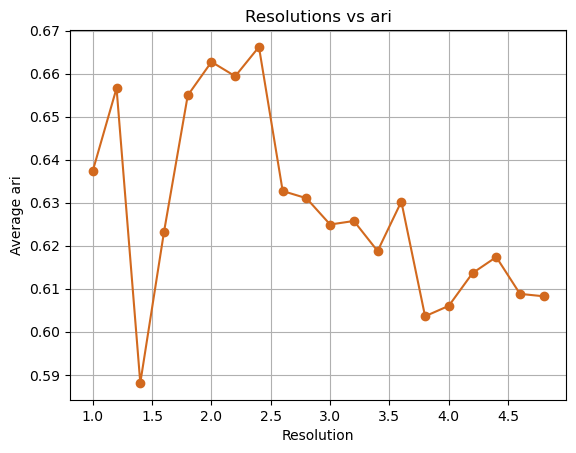

In [ ]:
plt.plot(resolutions, ari_means, marker='o', color = "chocolate")
plt.xlabel('Resolution')
plt.ylabel('Average ari')
plt.title('Resolutions vs ari')
plt.grid(True)
plt.show()

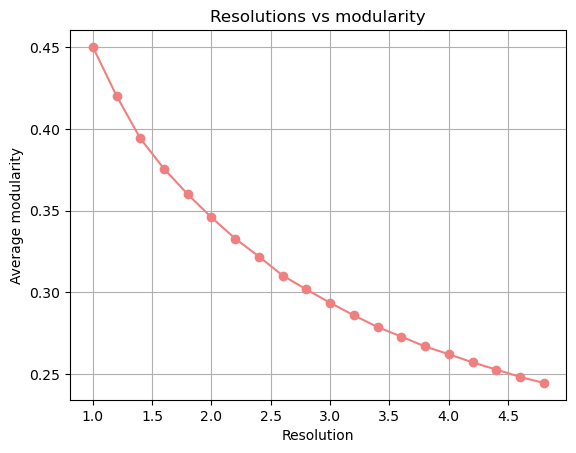

In [ ]:
plt.plot(resolutions, modularities, marker='o', color = "lightcoral")
plt.xlabel('Resolution')
plt.ylabel('Average modularity')
plt.title('Resolutions vs modularity')
plt.grid(True)
plt.show()

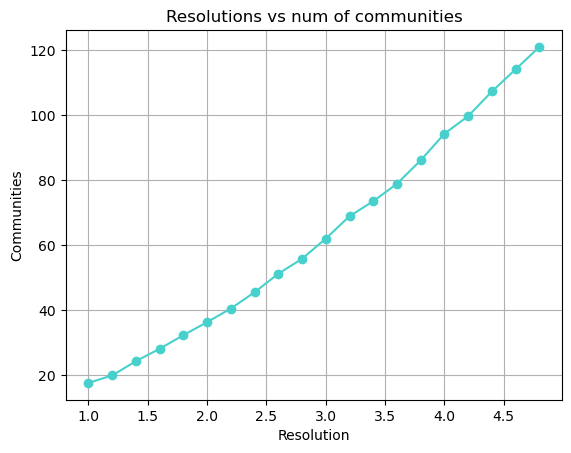

In [ ]:
plt.plot(resolutions, community_sizes, marker='o', color = "mediumturquoise")
plt.xlabel('Resolution')
plt.ylabel('Communities')
plt.title('Resolutions vs num of communities')
plt.grid(True)
plt.show()

In [ ]:
coms = nx.community.louvain_communities(G, seed=12, resolution=2.2)  ## tune these parameters
node_to_com_dict = {}
for i, community in enumerate(coms):  # create a dictionary of {node : community the node is in}
    for node in community:
        node_to_com_dict[node] = i
print(len(coms))

41


### Categorizing holes by community
List community (or communities) number and which holes appear in that group

In [ ]:
def categorize_holes(holes, node_to_community):
    categorized_holes = {}  # create a dictionary of {community number : [holes in community]}
    for hole in holes:
        communities_in_hole = set(node_to_community[node] for node in hole)  # how many unique communities the hole touches
        if len(communities_in_hole) == 1:
            community = communities_in_hole.pop()
            if community not in categorized_holes:
                categorized_holes[community] = []
            categorized_holes[community].append(hole)  # add hole to community dictionary entry
        else:
            community_tuple = tuple(sorted(communities_in_hole))
            if community_tuple not in categorized_holes:
                categorized_holes[community_tuple] = []
            categorized_holes[community_tuple].append(hole)  # add hole to community dictionary entry
    return categorized_holes

categorized_holes = categorize_holes(big_rep_cycle_list1, node_to_com_dict)

pprint.pprint(categorized_holes)

{1: [['market dynamic', 'stock price', 'trading strategy', 'interest rate'],
     ['insurance contract',
      'risky asset',
      'equivalent martingale measure',
      'minimal martingale measure',
      'stochastic interest rate'],
     ['black scholes model',
      'long range dependence',
      'interest rate',
      'contingent claim'],
     ['cox – ingersoll',
      'price process',
      'equivalent martingale measure',
      'mathematical finance'],
     ['local volatility model',
      'stochastic interest rate',
      'path dependent option',
      'option pricing model'],
     ['interest rate derivative',
      'stochastic interest rate',
      'minimal martingale measure',
      'contingent claim',
      'equivalent martingale measure',
      'interest rate'],
     ['currency exchange rate',
      'exchange rate',
      'econometric model',
      'contingent claim',
      'interest rate',
      'continuous time model'],
     ['capital market',
      'market price',
      

In [ ]:
def count_holes(holes, node_to_community):
    categorized_holes = defaultdict(list)
    for hole in holes:
        communities_in_hole = set(node_to_community[node] for node in hole)  # list of all the communities a hole touches
        if len(communities_in_hole) == 1:
            community = communities_in_hole.pop()
            categorized_holes[community].append(hole)
        else:
            community_tuple = tuple(sorted(communities_in_hole))
            categorized_holes[community_tuple].append(hole)
    return categorized_holes

counted_holes = count_holes(big_rep_cycle_list1, node_to_com_dict)
hole_counts = Counter()  # create a dictionary of {hole combo (int or tuple) : number of holes contained within the combo}
for key, holes in categorized_holes.items():
    hole_counts[key] = len(holes)

pprint.pprint(hole_counts)

Counter({7: 357,
         30: 217,
         (30, 33): 179,
         21: 125,
         1: 119,
         (5, 21): 103,
         (10, 33): 102,
         (19, 30): 100,
         (7, 17): 100,
         (7, 32): 93,
         33: 89,
         (19, 30, 33): 88,
         (7, 30): 82,
         (3, 21): 82,
         3: 79,
         (23, 30): 77,
         (7, 23): 75,
         5: 72,
         32: 71,
         (10, 30, 33): 70,
         19: 66,
         (10, 19, 30): 65,
         10: 59,
         (10, 30): 53,
         (3, 5, 21): 53,
         (10, 19): 52,
         (7, 17, 23): 50,
         (17, 23, 30): 49,
         38: 49,
         (1, 36): 48,
         (2, 5): 47,
         (7, 23, 30): 46,
         (21, 29): 46,
         (3, 40): 45,
         (5, 12, 21): 45,
         (7, 17, 30): 44,
         (24, 30): 44,
         (10, 12, 33): 42,
         (17, 30, 33): 42,
         (17, 30): 42,
         (12, 30): 41,
         (12, 33): 40,
         (12, 21): 40,
         (10, 19, 33): 40,
         (5, 40):

### Visualizations

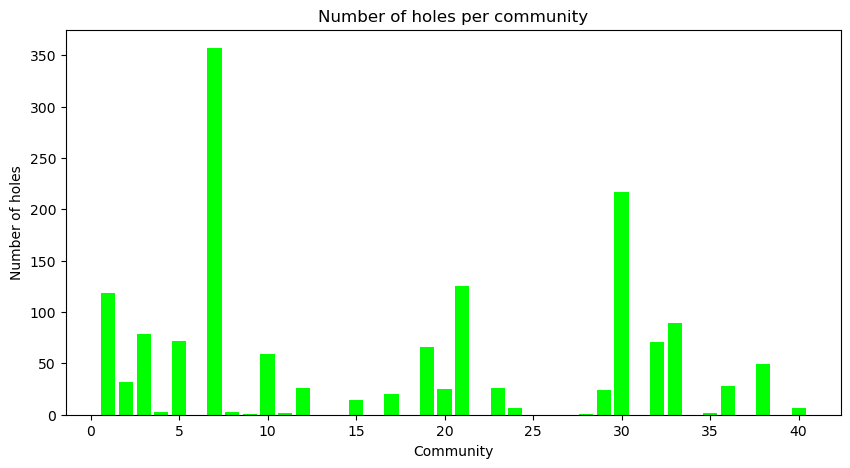

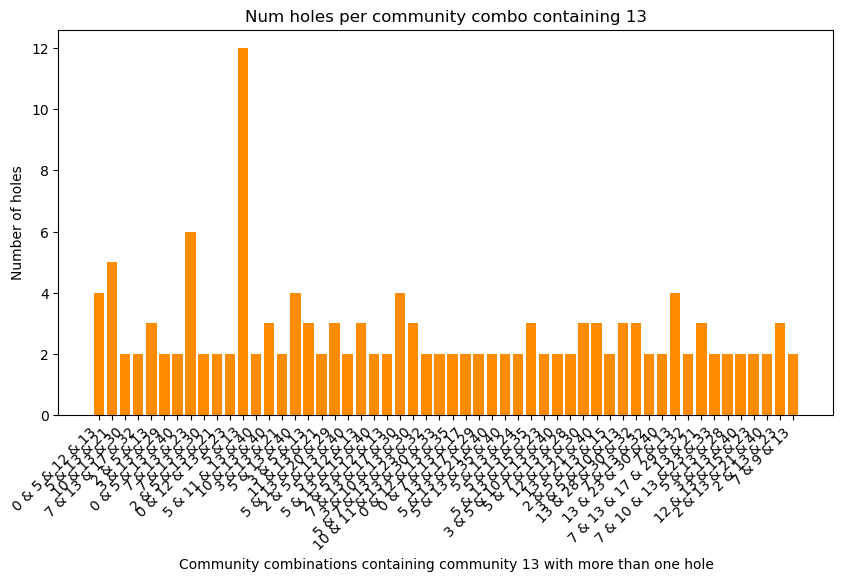

9 & 35
179


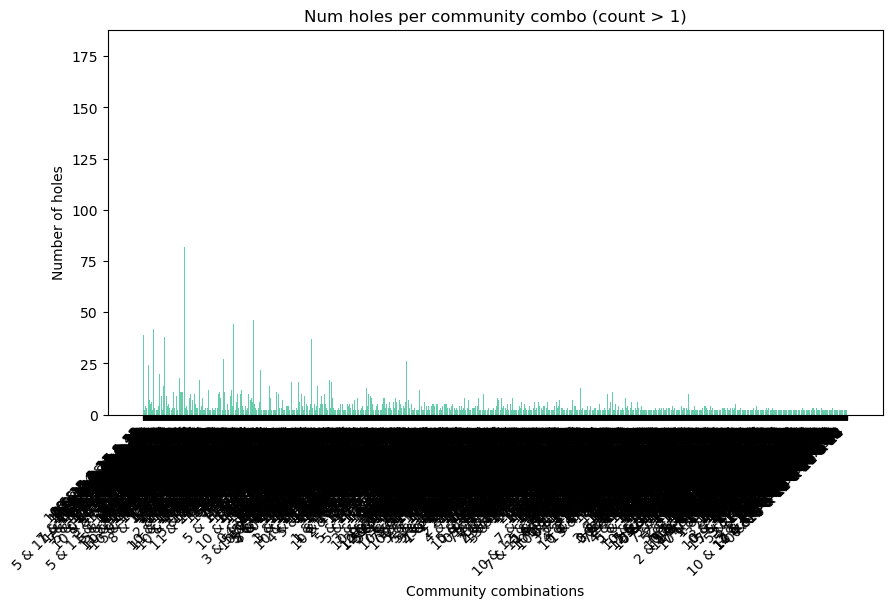

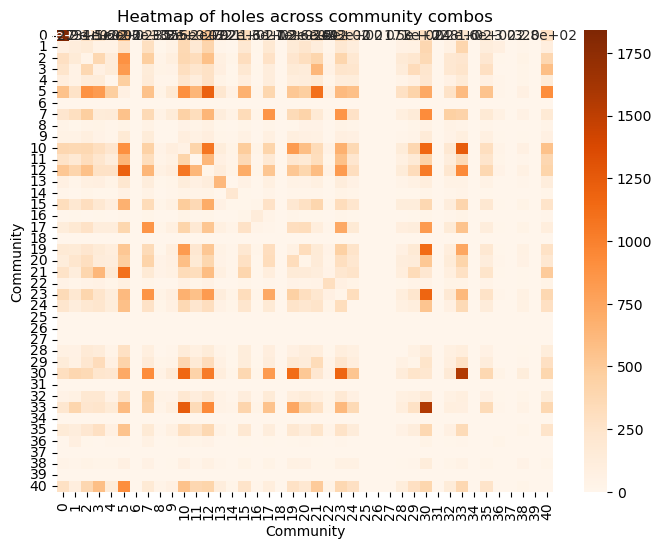

In [ ]:
individual_counts = {k: v for k, v in hole_counts.items() if isinstance(k, int)}  # number of holes contained within individual communities
combination_counts = {k: v for k, v in hole_counts.items() if isinstance(k, tuple)}  # number of holes contained within community combinations

plt.figure(figsize=(10, 5))
plt.bar(individual_counts.keys(), individual_counts.values(), color='lime')
plt.xlabel('Community')
plt.ylabel('Number of holes')
plt.title('Number of holes per community')
plt.show()

filtered_combination_counts = {k: v for k, v in hole_counts.items() if '13' in str(k) and v > 1}  # sanity check: 13 has many combo holes but few individual holes

if filtered_combination_counts:
    comb_keys = []
    for k in filtered_combination_counts.keys():
        if isinstance(k, int):
            comb_keys.append(str(k))
        else:
            comb_keys.append(' & '.join(map(str, k)))
    comb_values = list(filtered_combination_counts.values())
    plt.figure(figsize=(10, 5))
    plt.bar(comb_keys, comb_values, color='darkorange')
    plt.xlabel('Community combinations containing community 13 with more than one hole')
    plt.ylabel('Number of holes')
    plt.title('Num holes per community combo containing 13')
    plt.xticks(rotation=45, ha='right')
    plt.show()
else:
    print("No community combos with more than 1 hole")

filtered_combination_counts = {k: v for k, v in hole_counts.items() if isinstance(k, tuple) and v > 1}  # filter so only includes combos wiht >1 hole
if filtered_combination_counts:
    comb_keys = []
    for k in filtered_combination_counts.keys():
        if isinstance(k, int):
            comb_keys.append(str(k))
        else:
            comb_keys.append(' & '.join(map(str, k)))
    comb_values = list(filtered_combination_counts.values())
    plt.figure(figsize=(10, 5))
    print(max(comb_keys))
    print(max(comb_values))
    plt.bar(comb_keys, comb_values, color='mediumaquamarine')
    plt.xlabel('Community combinations')
    plt.ylabel('Number of holes')
    plt.title('Num holes per community combo (count > 1)')
    plt.xticks(rotation=45, ha='right')
    plt.show()
else:
    print("No community combos with more than 1 hole")

all_communities = sorted(set(node_to_com_dict.values()))
heatmap_data = np.zeros((len(all_communities), len(all_communities)))
for key, count in combination_counts.items():
    for i in range(len(key)):
        for j in range(i, len(key)):
            heatmap_data[key[i], key[j]] += count
            if i != j:
                heatmap_data[key[j], key[i]] += count

for community, count in individual_counts.items():
    heatmap_data[community, community] = count


plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, cmap='Oranges', xticklabels=all_communities, yticklabels=all_communities)
plt.xlabel('Community')
plt.ylabel('Community')
plt.title('Heatmap of holes across community combos')
plt.show()


Diagonal patterns indicate that communities have a high number of holes within themselves or similar structures. One important thing to note here is the discrepancy between the "number of holes per community" and the heatmap of holes across community combos. Take a look at community 13, for example. There are zero holes contained within the community, but the heatmap indicates that there are upwards of 60 holes that are partially within it.

### Repeat visualization from above with heavier filtering for readability

7 & 32
179


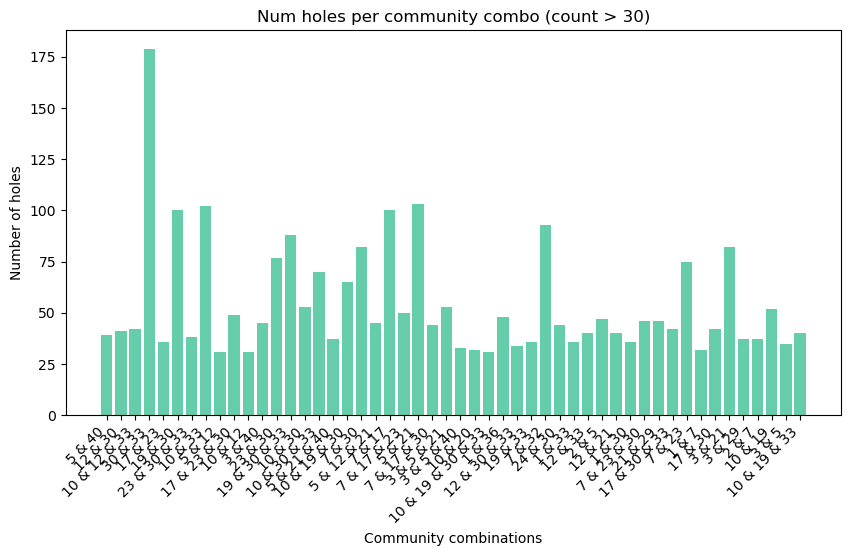

In [ ]:
filtered_combination_counts = {k: v for k, v in hole_counts.items() if isinstance(k, tuple) and v > 30}  # filter so only includes combos wiht >10 holes
if filtered_combination_counts:
    comb_keys = []
    for k in filtered_combination_counts.keys():
        if isinstance(k, int):
            comb_keys.append(str(k))
        else:
            comb_keys.append(' & '.join(map(str, k)))
    comb_values = list(filtered_combination_counts.values())
    plt.figure(figsize=(10, 5))
    print(max(comb_keys))
    print(max(comb_values))
    plt.bar(comb_keys, comb_values, color='mediumaquamarine')
    plt.xlabel('Community combinations')
    plt.ylabel('Number of holes')
    plt.title('Num holes per community combo (count > 30)')
    plt.xticks(rotation=45, ha='right')
    plt.show()
else:
    print("No community combos with more than 1 hole")

In [ ]:
filtered_combination_counts = {k: v for k, v in hole_counts.items() if '13' in str(k)}
print(filtered_combination_counts.keys())

dict_keys([(0, 5, 12, 13), (9, 13, 15, 17, 23, 35), (12, 13, 24), (12, 13, 23, 40), (10, 13, 19, 23), (7, 10, 13, 19, 29), (0, 13, 21, 35), (5, 13, 17, 21), (7, 13, 17, 28), (5, 13, 21), (3, 5, 13, 15, 30), (10, 13, 30), (0, 13, 40), (7, 13, 17, 32), (2, 13, 17, 40), (2, 13, 20, 24), (7, 13, 19, 24), (13, 17, 23, 28), (10, 13, 17), (2, 10, 13, 23, 30), (11, 13, 15, 19, 40), (1, 13, 17, 24), (1, 10, 11, 13), (3, 8, 13, 23, 40), (2, 5, 13), (3, 13, 29), (2, 3, 13, 19, 33), (10, 12, 13, 20, 30), (13, 23, 38), (4, 7, 13, 28), (7, 13, 24, 40), (3, 13), (2, 13), (0, 3, 13, 15, 21), (0, 5, 13, 40), (0, 2, 3, 13, 15), (8, 11, 13, 17, 19, 29), (0, 8, 13, 23, 24), (7, 13, 23), (2, 5, 9, 13), (13, 23, 40), (0, 10, 12, 13, 15, 17), (10, 11, 13), (1, 11, 12, 13, 23, 32), (2, 4, 5, 12, 13, 24, 40), (3, 5, 10, 11, 13, 15, 33), (7, 13, 30), (4, 5, 13), (4, 5, 13, 32), (3, 5, 13, 20, 33), (0, 10, 13, 19, 20, 30), (2, 5, 13, 21), (0, 12, 13, 23), (10, 13, 20, 23, 24), (0, 3, 5, 13, 30), (0, 10, 13, 24),

In [ ]:
all_communities = sorted(set(node_to_com_dict.values()))
num_communities = len(all_communities)
heatmap_data_3d = np.zeros((num_communities, num_communities, num_communities))

for key, count in combination_counts.items():
    for i in range(len(key)):
        for j in range(i, len(key)):
            for k in range(j, len(key)):
                heatmap_data_3d[key[i], key[j], key[k]] += count
                if i != j:
                    heatmap_data_3d[key[j], key[i], key[k]] += count
                if i != k:
                    heatmap_data_3d[key[k], key[j], key[i]] += count
                if j != k:
                    heatmap_data_3d[key[i], key[k], key[j]] += count

for community, count in individual_counts.items():
    heatmap_data_3d[community, community, community] = count

x, y, z = np.indices((num_communities, num_communities, num_communities))
x = x.flatten()
y = y.flatten()
z = z.flatten()
holes_flat = heatmap_data_3d.flatten()

non_zero_indices = holes_flat > 0
x = x[non_zero_indices]
y = y[non_zero_indices]
z = z[non_zero_indices]
holes_flat = holes_flat[non_zero_indices]

fig = go.Figure(data=[go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker=dict(
        size=5,
        color=holes_flat,
        colorscale='pubu',
        colorbar=dict(title='Number of Holes'),
        opacity=0.8
    )
)])

fig.update_layout(
    scene=dict(
        xaxis_title='Community 1',
        yaxis_title='Community 2',
        zaxis_title='Community 3'
    ),
    title='3D heatmap of holes by community combo',
    width=800,
    height=800 
)

fig.show()


### Collapse each community into a node. Plot cross-community edges. 

In [ ]:
collapsed_G = nx.Graph()

# Add nodes for each community
for i in range(len(coms)):
    collapsed_G.add_node(i)

# Add edges between communities
for u, v in G.edges():
    community_u = node_to_com_dict[u]
    community_v = node_to_com_dict[v]
    if community_u != community_v:
        if collapsed_G.has_edge(community_u, community_v):
            collapsed_G[community_u][community_v]['weight'] += 1
        else:
            collapsed_G.add_edge(community_u, community_v, weight=1)

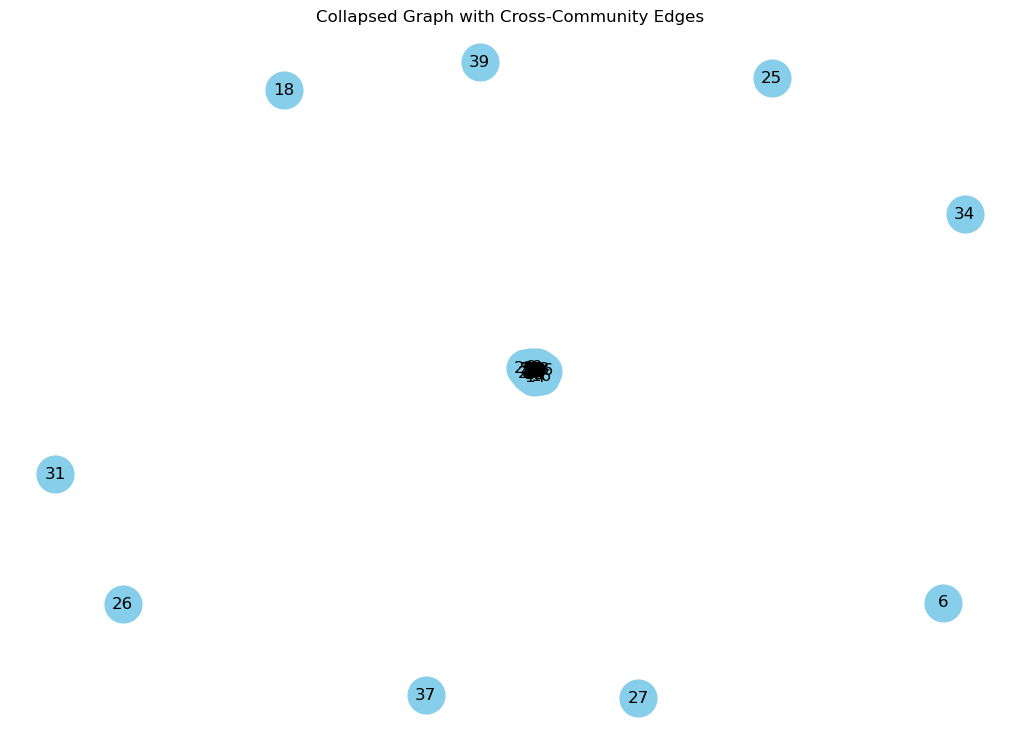

In [ ]:
pos = nx.spring_layout(collapsed_G)
weights = [collapsed_G[u][v]['weight'] for u, v in collapsed_G.edges()]

plt.figure(figsize=(10, 7))
nx.draw(collapsed_G, pos, with_labels=True, node_size=700, node_color='skyblue', edge_color=weights, width=2.0, edge_cmap=plt.cm.Blues)
nx.draw_networkx_edge_labels(collapsed_G, pos, edge_labels={(u, v): d['weight'] for u, v, d in collapsed_G.edges(data=True)})

plt.title("Collapsed Graph with Cross-Community Edges")
plt.show()

## Can you highlight holes that span communities and link different communities together?

In [ ]:
# re-collapse graph
collapsed_G = nx.Graph()

for i in range(len(coms)):
    collapsed_G.add_node(i)

hole_adjacent_edge_count = {}  # track the number of hole-adjacent edges between communities
total_edge_count = {}

# create a set of cycle edges based on the original node cycles
cycle_edges = set()
for cycle in big_rep_cycle_list1:
    for i in range(len(cycle)):
        u, v = cycle[i], cycle[(i + 1) % len(cycle)]
        community_u = node_to_com_dict[u]
        community_v = node_to_com_dict[v]
        if community_u != community_v:
            cycle_edges.add((community_u, community_v))
            cycle_edges.add((community_v, community_u))

# add the edges between communities
for u, v in G.edges():
    community_u = node_to_com_dict[u]
    community_v = node_to_com_dict[v]
    if community_u != community_v:
        if collapsed_G.has_edge(community_u, community_v):
            collapsed_G[community_u][community_v]['weight'] += 1
        else:
            collapsed_G.add_edge(community_u, community_v, weight=1)
        
        if (community_u, community_v) not in total_edge_count:
            total_edge_count[(community_u, community_v)] = 0
            hole_adjacent_edge_count[(community_u, community_v)] = 0
        
        total_edge_count[(community_u, community_v)] += 1
        
        if (community_u, community_v) in cycle_edges or (community_v, community_u) in cycle_edges:
            hole_adjacent_edge_count[(community_u, community_v)] += 1

# get proportions of hole-adjacency for color gradient
edge_proportions = {edge: hole_adjacent_edge_count[edge] / total_edge_count[edge] for edge in total_edge_count}
#randomly position nodes in 3d space
pos = {i: (np.random.random(), np.random.random(), np.random.random()) for i in collapsed_G.nodes}

# do edge traces
edge_trace = []
for edge in collapsed_G.edges():
    x0, y0, z0 = pos[edge[0]]
    x1, y1, z1 = pos[edge[1]]
    proportion = edge_proportions.get(edge, 0)
    color = f'rgb({int(255 * (1 - proportion))}, 0, {int(255 * proportion)})'
    
    edge_trace.append(go.Scatter3d(
        x=[x0, x1, None],
        y=[y0, y1, None],
        z=[z0, z1, None],
        line=dict(width=5, color=color),
        hoverinfo='none',
        mode='lines'
    ))

non_cycle_edge_count = len([e for e in collapsed_G.edges() if e not in cycle_edges and (e[1], e[0]) not in cycle_edges])
print(f"Number of edges not part of any cycle: {non_cycle_edge_count}")

# do node traces
node_trace = go.Scatter3d(
    x=[pos[node][0] for node in collapsed_G.nodes()],
    y=[pos[node][1] for node in collapsed_G.nodes()],
    z=[pos[node][2] for node in collapsed_G.nodes()],
    mode='markers',
    marker=dict(
        size=7,
        color='black',
    ),
    text=list(collapsed_G.nodes()),
    hoverinfo='text'
)


layout = go.Layout(
    width=800,
    height=800,
    showlegend=False,
    scene=dict(
        xaxis=dict(showbackground=False),
        yaxis=dict(showbackground=False),
        zaxis=dict(showbackground=False)
    ),
)

fig = go.Figure(data=edge_trace + [node_trace], layout=layout)
fig.show()


Number of edges not part of any cycle: 5


In [ ]:
collapsed_G = nx.Graph()

for i in range(len(coms)):
    collapsed_G.add_node(i)

hole_adjacent_edge_count = {}
total_edge_count = {}

original_cycle_edges = set()
for cycle in big_rep_cycle_list1:
    for i in range(len(cycle)):
        u, v = cycle[i], cycle[(i + 1) % len(cycle)]
        original_cycle_edges.add((u, v))
        original_cycle_edges.add((v, u))

for u, v in G.edges():
    community_u = node_to_com_dict[u]
    community_v = node_to_com_dict[v]
    if community_u != community_v:
        if collapsed_G.has_edge(community_u, community_v):
            collapsed_G[community_u][community_v]['weight'] += 1
        else:
            collapsed_G.add_edge(community_u, community_v, weight=1)
        
        if (community_u, community_v) not in total_edge_count:
            total_edge_count[(community_u, community_v)] = 0
            hole_adjacent_edge_count[(community_u, community_v)] = 0
        
        total_edge_count[(community_u, community_v)] += 1
        
        if (u, v) in original_cycle_edges or (v, u) in original_cycle_edges:
            hole_adjacent_edge_count[(community_u, community_v)] += 1

edge_proportions = {edge: hole_adjacent_edge_count[edge] / total_edge_count[edge] for edge in total_edge_count}

pos = {i: (np.random.random(), np.random.random(), np.random.random()) for i in collapsed_G.nodes}

edge_trace = []
for edge in collapsed_G.edges():
    x0, y0, z0 = pos[edge[0]]
    x1, y1, z1 = pos[edge[1]]
    proportion = edge_proportions.get(edge, 0)
    color = f'rgb({int(255 * (1 - proportion))}, 0, {int(255 * proportion)})'
    
    edge_trace.append(go.Scatter3d(
        x=[x0, x1, None],
        y=[y0, y1, None],
        z=[z0, z1, None],
        line=dict(width=5, color=color),
        hoverinfo='none',
        mode='lines'
    ))

# map original cycle edges to community edges
collapsed_cycle_edges = set()
for u, v in original_cycle_edges:
    community_u = node_to_com_dict[u]
    community_v = node_to_com_dict[v]
    if community_u != community_v:
        collapsed_cycle_edges.add((community_u, community_v))
        collapsed_cycle_edges.add((community_v, community_u))

# count edges part of any cycle and not part of any cycle
cycle_edge_count = len([e for e in collapsed_G.edges() if (e in collapsed_cycle_edges or (e[1], e[0]) in collapsed_cycle_edges)])
non_cycle_edge_count = len(collapsed_G.edges()) - cycle_edge_count

# calculate percentages for gradient
total_edges = len(collapsed_G.edges())
percent_non_cycle = (non_cycle_edge_count / total_edges) * 100
percent_cycle = (cycle_edge_count / total_edges) * 100

print(f"Number of edges not part of any cycle: {non_cycle_edge_count} ({percent_non_cycle:.2f}%)")
print(f"Number of edges part of a cycle: {cycle_edge_count} ({percent_cycle:.2f}%)")

node_trace = go.Scatter3d(
    x=[pos[node][0] for node in collapsed_G.nodes()],
    y=[pos[node][1] for node in collapsed_G.nodes()],
    z=[pos[node][2] for node in collapsed_G.nodes()],
    mode='markers',
    marker=dict(
        size=7,
        color='black',
    ),
    text=list(collapsed_G.nodes()),
    hoverinfo='text'
)

# do color bar/key
color_bar_trace = go.Scatter3d(
    x=[None], y=[None], z=[None],
    mode='markers',
    marker=dict(
        size=0,
        color=[0, 1], 
        colorscale=[[0, 'rgb(255, 0, 0)'], [1, 'rgb(0, 0, 255)']],
        colorbar=dict(
            title="Proportion of Hole-Adjacent Edges",
            tickvals=[0, 1],
            ticktext=["0% (Red)", "100% (Blue)"]
        )
    ),
    hoverinfo='none'
)

layout = go.Layout(
    width=1200,
    height=1000,
    showlegend=False,
    scene=dict(
        xaxis=dict(showbackground=False),
        yaxis=dict(showbackground=False),
        zaxis=dict(showbackground=False)
    ),
)

fig = go.Figure(data=edge_trace + [node_trace, color_bar_trace], layout=layout)
fig.show()


Number of edges not part of any cycle: 5 (1.02%)
Number of edges part of a cycle: 486 (98.98%)


In [ ]:
collapsed_G = nx.Graph()

for i in range(len(coms)):
    collapsed_G.add_node(i)

hole_adjacent_edge_count = {}
total_edge_count = {}

original_cycle_edges = set()
for cycle in big_rep_cycle_list1:
    for i in range(len(cycle)):
        u, v = cycle[i], cycle[(i + 1) % len(cycle)]
        original_cycle_edges.add((u, v))
        original_cycle_edges.add((v, u))

for u, v in G.edges():
    community_u = node_to_com_dict[u]
    community_v = node_to_com_dict[v]
    if community_u != community_v:
        if collapsed_G.has_edge(community_u, community_v):
            collapsed_G[community_u][community_v]['weight'] += 1
        else:
            collapsed_G.add_edge(community_u, community_v, weight=1)
        
        if (community_u, community_v) not in total_edge_count:
            total_edge_count[(community_u, community_v)] = 0
            hole_adjacent_edge_count[(community_u, community_v)] = 0
        
        total_edge_count[(community_u, community_v)] += 1
        
        if (u, v) in original_cycle_edges or (v, u) in original_cycle_edges:
            hole_adjacent_edge_count[(community_u, community_v)] += 1

edge_proportions = {edge: hole_adjacent_edge_count[edge] / total_edge_count[edge] for edge in total_edge_count}

# get and normalize weight
weights = [data['weight'] for u, v, data in collapsed_G.edges(data=True)]
min_weight = min(weights)
max_weight = max(weights)
norm_weights = {edge: 3 + 12 * (data['weight'] - min_weight) / (max_weight - min_weight) for edge, data in collapsed_G.edges.items()}

pos = {i: (np.random.random(), np.random.random(), np.random.random()) for i in collapsed_G.nodes}

edge_trace = []
for edge in collapsed_G.edges(data=True):
    x0, y0, z0 = pos[edge[0]]
    x1, y1, z1 = pos[edge[1]]
    proportion = edge_proportions.get((edge[0], edge[1]), 0)
    color = f'rgb({int(255 * (1 - proportion))}, 0, {int(255 * proportion)})'
    weight = norm_weights[(edge[0], edge[1])]  # use weight for thickness of edge
    
    edge_trace.append(go.Scatter3d(
        x=[x0, x1, None],
        y=[y0, y1, None],
        z=[z0, z1, None],
        line=dict(width=weight, color=color),  # use weight for thickness
        hoverinfo='none',
        mode='lines'
    ))

collapsed_cycle_edges = set()
for u, v in original_cycle_edges:
    community_u = node_to_com_dict[u]
    community_v = node_to_com_dict[v]
    if community_u != community_v:
        collapsed_cycle_edges.add((community_u, community_v))
        collapsed_cycle_edges.add((community_v, community_u))

cycle_edge_count = len([e for e in collapsed_G.edges() if (e in collapsed_cycle_edges or (e[1], e[0]) in collapsed_cycle_edges)])
non_cycle_edge_count = len(collapsed_G.edges()) - cycle_edge_count

total_edges = len(collapsed_G.edges())
percent_non_cycle = (non_cycle_edge_count / total_edges) * 100
percent_cycle = (cycle_edge_count / total_edges) * 100

print(f"Number of edges not part of any cycle: {non_cycle_edge_count} ({percent_non_cycle:.2f}%)")
print(f"Number of edges part of a cycle: {cycle_edge_count} ({percent_cycle:.2f}%)")

node_trace = go.Scatter3d(
    x=[pos[node][0] for node in collapsed_G.nodes()],
    y=[pos[node][1] for node in collapsed_G.nodes()],
    z=[pos[node][2] for node in collapsed_G.nodes()],
    mode='markers',
    marker=dict(
        size=7,
        color='black',
    ),
    text=list(collapsed_G.nodes()),
    hoverinfo='text'
)

color_bar_trace = go.Scatter3d(
    x=[None], y=[None], z=[None],
    mode='markers',
    marker=dict(
        size=0,
        color=[0, 1],
        colorscale=[[0, 'rgb(255, 0, 0)'], [1, 'rgb(0, 0, 255)']],
        colorbar=dict(
            title="Proportion of Hole-Adjacent Edges",
            tickvals=[0, 1],
            ticktext=["0% (Red)", "100% (Blue)"]
        )
    ),
    hoverinfo='none'
)

layout = go.Layout(
    width=1200,
    height=1000,
    showlegend=False,
    scene=dict(
        xaxis=dict(showbackground=False),
        yaxis=dict(showbackground=False),
        zaxis=dict(showbackground=False)
    ),
)

fig = go.Figure(data=edge_trace + [node_trace, color_bar_trace], layout=layout)
fig.show()

Number of edges not part of any cycle: 5 (1.02%)
Number of edges part of a cycle: 486 (98.98%)


## TODO

- Topic modeling methods
- ~~Gradient for 3D Graph~~
- ~~Change cycle size to follow distribution of holes~~
- Get communities over time

In [ ]:
holes_contained_in_one_com = 0
coms_with_holes = {key for key in hole_counts.keys() if isinstance(key,int)}
for thing in coms_with_holes:
    holes_contained_in_one_com += hole_counts[thing]
pct = (holes_contained_in_one_com/sum(hole_counts.values())) * 100

labels = ["Percent of Holes Contained by One Community", "Percent of Holes That Span Communities"]
values = [pct, 100-pct]
colors = ['grey', 'blue']

fig = go.Figure(data=[go.Pie(labels=labels, values=values, marker=dict(colors=colors))])

fig.update_layout(
    title="Hole Containment in Communities",
)

fig.show()
print(f"Total holes: {sum(hole_counts.values())}")
print(f"Holes that Span Communities: {sum(hole_counts.values())-holes_contained_in_one_com}")
print(f"Holes Contained by One Community: {holes_contained_in_one_com}")


Total holes: 20810
Holes that Span Communities: 19286
Holes Contained by One Community: 1524


### Disconnected communities
We can see in the above collapsed graph that there are a number of communities that have zero connections to other communities. Let's take a closer look at them and see if they contain any holes.

In [ ]:
# print(list(nx.isolates(collapsed_G)))
for hole in list(nx.isolates(collapsed_G)):
    print(f"Community {hole} contains {hole_counts[hole]} holes")

Community 6 contains 0 holes
Community 18 contains 0 holes
Community 25 contains 0 holes
Community 26 contains 0 holes
Community 27 contains 0 holes
Community 31 contains 0 holes
Community 34 contains 0 holes
Community 37 contains 0 holes
Community 39 contains 0 holes


In [ ]:
for hole in list(nx.isolates(collapsed_G)):
    print(coms[hole])

{'capillary gravity wave'}
{'heavy metal'}
{'local government'}
{'mathematical community'}
{'modulus of elasticity'}
{'regular languages', 'context free language'}
{'planetary system', 'solar system'}
{'temperature gradient'}
{'ultrashort laser pulse'}


In [ ]:
print(len(list(nx.isolates(G))))

7


### Find communities with no holes

In [ ]:
all_communities = set(range(len(coms)))
coms_with_holes = {key for key in hole_counts.keys() if isinstance(key, int)}
coms_with_no_holes = all_communities - coms_with_holes

print("Communities with no holes:", coms_with_no_holes)
print("Communities with holes:", coms_with_holes)

Communities with no holes: {0, 34, 37, 6, 39, 13, 14, 16, 18, 22, 25, 26, 27, 31}
Communities with holes: {1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 15, 17, 19, 20, 21, 23, 24, 28, 29, 30, 32, 33, 35, 36, 38, 40}


### Check size of communities
Ultimately, all the above data should be visualized relative to community size. It's more significant if a small community has three holes than a very very large community

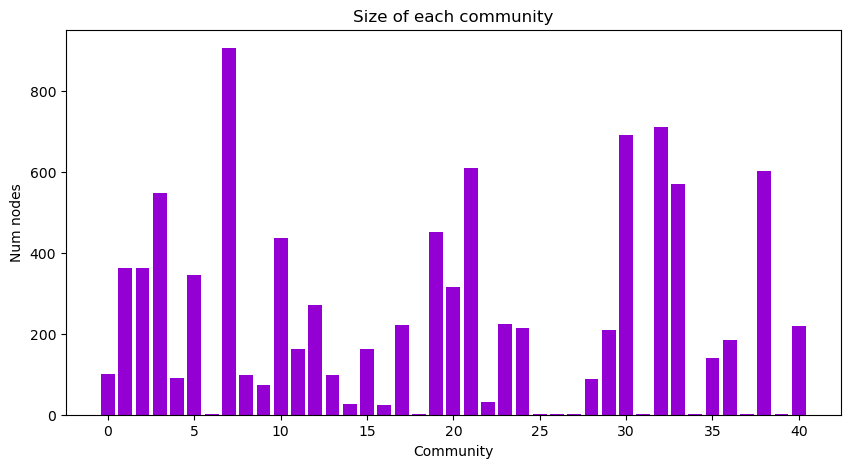

In [ ]:
community_sizes = Counter(node_to_com_dict.values())

plt.figure(figsize=(10, 5))
plt.bar(community_sizes.keys(), community_sizes.values(), color='darkviolet')
plt.xlabel('Community')
plt.ylabel('Num nodes')
plt.title('Size of each community')
plt.show()

In [ ]:
print(coms[11])

{'optimal control scheme', 'optimal tracking control problem', 'index function', 'apply mathematical sciences', 'performance guarantee', 'direct yaw moment control', 'optimal feedback controller', 'optimality principle', 'such nonlinear system', 'adaptive dynamic programming technique', 'control solution', 'inverse optimal control approach', 'zero sum game', 'value function approximation', 'adaptive optimal control', 'infinite horizon cost', 'single input nonlinear system', 'rigorous convergence analysis', 'performance index function', 'iterative adaptive dynamic programming adp algorithm', 'global optimal control', 'uncertain dynamic', 'adaptive dynamic programming adp algorithm', 'optimal output feedback control', 'control process', 'optimal tracking control', 'linear quadratic gaussian', 'performance criterion', 'iteration algorithm', 'optimal control input', 'real time optimal control', 'average cost criterion', 'classical optimal control problem', 'deterministic nonlinear system',

### Turn list of cycles into list of concepts allowing duplicates. Then see if there are specific communities with disproportionate amounts of concepts connected to holes.

In [ ]:
concept_set = list(set(str(big_rep_cycle_list1).replace("[", "").replace("]", "").replace("'", "").split(",")))
clean_concept_set = []  # set of all unique concepts that are part of at least on cycle/hole
for item in concept_set:
    clean_concept_set.append(item.strip())
prop_of_hole_concepts = []
communities_count = []
com_count = 0
for community in coms:
    count_prop = 0
    for thing in community:
        if thing.strip() in clean_concept_set:
            count_prop += 1
    prop_of_hole_concepts.append(count_prop/len(community))
    communities_count.append(com_count)
    com_count+=1
print(prop_of_hole_concepts)
print(communities_count)

[0.89, 0.7955801104972375, 0.9030470914127424, 0.7591240875912408, 0.8777777777777778, 0.9421965317919075, 0.0, 0.8397790055248618, 0.5204081632653061, 0.9054054054054054, 0.9333333333333333, 0.8773006134969326, 0.8851851851851852, 0.7959183673469388, 0.9230769230769231, 0.9565217391304348, 0.92, 0.9234234234234234, 0.0, 0.8119469026548672, 0.8920634920634921, 0.8289473684210527, 1.0, 0.9598214285714286, 0.9295774647887324, 0.0, 0.0, 0.0, 0.898876404494382, 0.8571428571428571, 0.91027496382055, 0.0, 0.5056338028169014, 0.9033391915641477, 0.0, 0.9078014184397163, 0.6086956521739131, 0.0, 0.3560732113144759, 0.0, 0.9269406392694064]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]


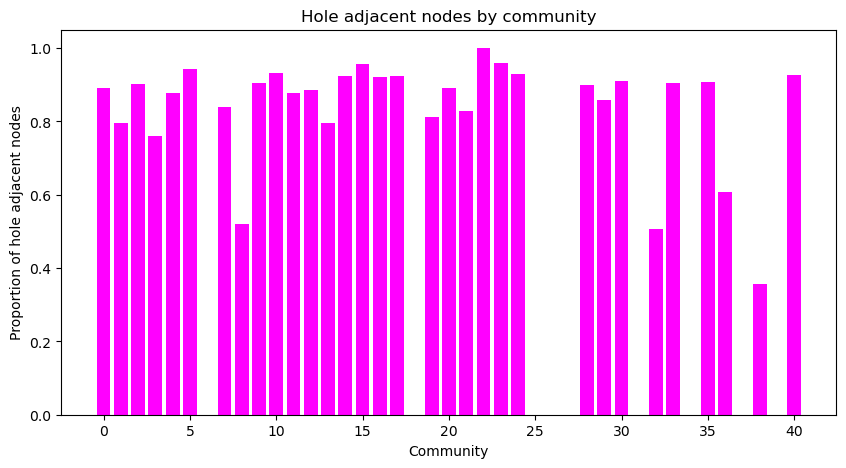

In [ ]:

plt.figure(figsize=(10, 5))
plt.bar(communities_count, prop_of_hole_concepts, color='magenta')
plt.xlabel('Community')
plt.ylabel('Proportion of hole adjacent nodes')
plt.title('Hole adjacent nodes by community')
plt.show()

### Categorize holes via labeled communities
Can a hole be characterized via the communities it is a part of?

In [ ]:
print(big_rep_cycle_list1[1])

['optimal feedback control system', 'time optimal control system', 'linear feedback system', 'optimal control function', 'optimal open loop control']


In [ ]:
# combos = []
# for index in range(5):
#     combo = comb_keys[comb_values.index(sorted(comb_values, reverse=True)[index])]
#     combos.append(combo)

# combos = list(set(combos))

# for combo in combos:
#     print(f"There are {comb_values[comb_keys.index(combo)]} holes in the community combo {combo}, labeled as:")
#     combo_list = combo.split(" & ")
#     cs = []
#     for c in combo_list:
#         cs.append(coms_labels_gpt4[int(c)])
#     print(" & ".join(cs), "\n")

There are 103 holes in the community combo 5 & 21, labeled as:
Adaptive and Robust Control Systems in Nonlinear and Uncertain Environments & Numerical Methods and Optimization in Differential Equations and Control Systems 

There are 100 holes in the community combo 19 & 30, labeled as:
Model Predictive Control and Optimization in Complex Dynamical Systems & Stochastic Dynamics and Control 

There are 179 holes in the community combo 30 & 33, labeled as:
Stochastic Dynamics and Control & Optimal Control and Game Theory 

There are 102 holes in the community combo 10 & 33, labeled as:
Control and Synchronization in Stochastic and Networked Systems & Optimal Control and Game Theory 



### To label holes like this, we need to consider what it looks like for cycles spanning many holes. 

The first step is finding out how many cycles span large numbers of holes

In [ ]:
community_combo_counts = {}
for key, value in categorized_holes.items():
    if isinstance(key,tuple):
        if len(key) > 10:
            print(len(value[0]))
            print(value[0])
        if len(key) in community_combo_counts.keys():
            community_combo_counts[len(key)] += len(value)
        else:
            community_combo_counts[len(key)] = len(value)
    elif isinstance(key, int):
        if 1 in community_combo_counts.keys():
            community_combo_counts[1] += len(value)
        else:
            community_combo_counts[1] = len(value)
print(community_combo_counts)

{4: 6093, 5: 2702, 6: 669, 2: 3445, 3: 6232, 1: 1524, 7: 116, 8: 24, 9: 4, 10: 1}


In [ ]:
community_combo_counts

{4: 6093,
 5: 2702,
 6: 669,
 2: 3445,
 3: 6232,
 1: 1524,
 7: 116,
 8: 24,
 9: 4,
 10: 1}

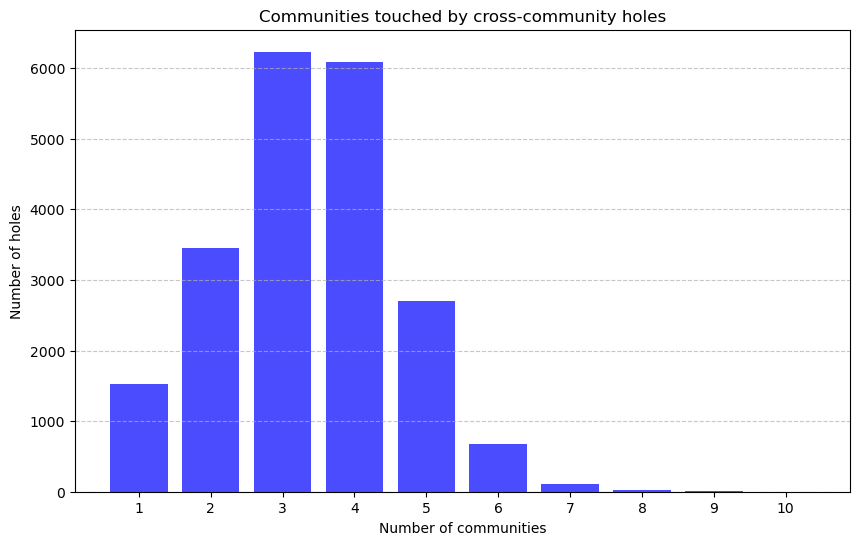

In [ ]:
sorted_data = dict(sorted(community_combo_counts.items()))

keys = list(sorted_data.keys())
values = list(sorted_data.values())

plt.figure(figsize=(10, 6))
plt.bar(keys, values, color='blue', alpha=0.7)
plt.xlabel('Number of communities')
plt.ylabel('Number of holes')
plt.title('Communities touched by cross-community holes')
plt.xticks(keys)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
result_list = [key for key, count in community_combo_counts.items() for _ in range(count)]

### How does this distribution compare to a random selection of 20k cycles (not homological holes)?

First, we'll select random cycles by walking through the network

In [ ]:
import random

def find_random_cycle(G, max_steps=1000):
    nodes = list(G.nodes)
    if not nodes:
        return None
    start_node = random.choice(nodes)
    visited = {}
    path = []
    current_node = start_node
    for _ in range(max_steps):
        if current_node in visited:
            cycle_start_index = visited[current_node]
            cycle = path[cycle_start_index:]
            return cycle
        visited[current_node] = len(path)
        path.append(current_node)
        neighbors = list(G.neighbors(current_node))
        if not neighbors:
            break
        current_node = random.choice(neighbors)
    return None

random_cycle = find_random_cycle(G)
if random_cycle:
    print("Randomly selected cycle:", random_cycle)
else:
    print("No cycle found in the graph")

Randomly selected cycle: ['empirical result', 'future market']


We filter the cycles to only include ones greater than a certain length. Currently, this is set to 5. But it could be changed to 4 (the minimum length of a homological hole cycle) or some other value, such as the mean length of a homological hole cycle. Additionally, we could add a maximum length

In [ ]:
rand_cycle = find_random_cycle(G)
while len(rand_cycle)<5:
    rand_cycle = find_random_cycle(G)
print(rand_cycle)

['sufficient stability condition', 'estimation error', 'measurement noise', 'linear distribute parameter system', 'multiobjective optimal control problem', 'weight sum method', 'filter design problem', 'such optimization problem', 'second order information', 'variational analysis', 'set value mapping', 'reflexive banach space', 'mixed equilibrium problem', 'iterative scheme', 'reliability base design optimization', 'design optimization method', 'design optimization', 'class of method', 'extremum seek control', 'multiple input system', 'singular control problem', 'penalty method', 'fast fourier transform', 'time step', 'high dimensional state space', 'high dimension', 'kolmogorov equation', 'regularity property', 'linear functional differential equation', 'high dimensional partial differential equation', 'nonlinear black – scholes equation', 'call option', 'equivalent martingale measure', 'stock price process', 'stochastic process theory', 'stochastic neural network', 'mean square expon

In [ ]:
cycle_communities = [node_to_com_dict[node] for node in random_cycle]
unique_communities = set(cycle_communities)
len(unique_communities)

1

In [ ]:
hole_lengths = []
for item in big_rep_cycle_list1:
    hole_lengths.append(len(item))

In [ ]:
print(hole_lengths)

[5, 5, 5, 9, 5, 5, 6, 5, 5, 5, 5, 5, 6, 6, 5, 4, 4, 8, 6, 7, 7, 5, 4, 6, 8, 5, 4, 5, 5, 5, 7, 4, 6, 5, 6, 7, 4, 5, 8, 7, 7, 5, 4, 8, 5, 5, 6, 6, 7, 4, 4, 6, 6, 4, 7, 6, 5, 4, 5, 6, 7, 5, 6, 6, 6, 7, 5, 5, 5, 6, 6, 5, 4, 6, 4, 5, 5, 6, 5, 5, 6, 5, 6, 5, 4, 9, 5, 5, 4, 7, 6, 6, 5, 5, 5, 6, 7, 4, 7, 4, 6, 6, 7, 6, 6, 5, 8, 6, 5, 5, 5, 7, 5, 5, 4, 5, 5, 4, 5, 7, 7, 5, 4, 6, 5, 4, 6, 6, 6, 4, 5, 4, 4, 5, 6, 5, 5, 6, 5, 6, 7, 6, 6, 5, 4, 4, 6, 4, 4, 5, 5, 6, 7, 5, 6, 7, 5, 4, 6, 4, 6, 5, 4, 5, 5, 5, 5, 5, 6, 7, 5, 4, 6, 4, 5, 7, 7, 7, 5, 7, 4, 5, 6, 5, 6, 6, 5, 6, 8, 4, 7, 6, 7, 6, 4, 5, 5, 5, 5, 4, 4, 5, 8, 4, 4, 4, 7, 7, 4, 5, 4, 8, 6, 5, 7, 6, 4, 5, 4, 4, 5, 5, 4, 5, 4, 5, 6, 4, 6, 5, 8, 5, 7, 5, 4, 7, 4, 5, 5, 4, 5, 4, 5, 5, 6, 6, 5, 5, 6, 5, 4, 5, 6, 6, 5, 6, 7, 6, 6, 6, 6, 5, 7, 5, 6, 5, 5, 6, 7, 6, 4, 4, 5, 5, 4, 6, 4, 6, 5, 6, 4, 4, 5, 6, 4, 4, 4, 4, 6, 5, 4, 7, 5, 6, 5, 7, 4, 5, 5, 7, 5, 6, 5, 7, 5, 5, 5, 4, 7, 6, 4, 5, 4, 5, 4, 6, 5, 7, 6, 4, 6, 4, 5, 7, 5, 5, 4, 8, 4, 5, 4, 6, 5, 

In [ ]:
found_cycles = []
unique_coms = []
hole_lengths_index = 0
for n in range(20810):
    rand_cycle = find_random_cycle(G)
    # print(rand_cycle)
    while (not rand_cycle) or (len(rand_cycle)!= hole_lengths[hole_lengths_index]) or (rand_cycle in found_cycles):
        rand_cycle = find_random_cycle(G)
    found_cycles.append(rand_cycle)
    cycle_communities = [node_to_com_dict[node] for node in rand_cycle]
    unique_communities = set(cycle_communities)
    unique_coms.append(len(unique_communities))
    hole_lengths_index+=1

In [ ]:
print(len(unique_coms))
print(len(result_list))

20810
20810


### Now we have a list of 20810 random cycles and 20810 holes. Lets compare the number of communities they're touching.

20810


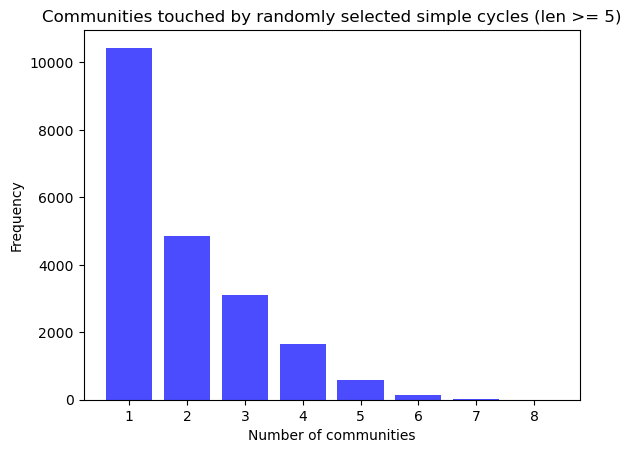

In [ ]:
from collections import Counter
print(len(unique_coms))
value_counts = Counter(unique_coms)
x = list(range(1, max(unique_coms)+1))
y = [value_counts.get(i, 0) for i in x]

plt.bar(x, y, color='blue', alpha=0.7)
plt.xlabel('Number of communities')
plt.ylabel('Frequency')
plt.title('Communities touched by randomly selected simple cycles (len >= 5)')
plt.show()

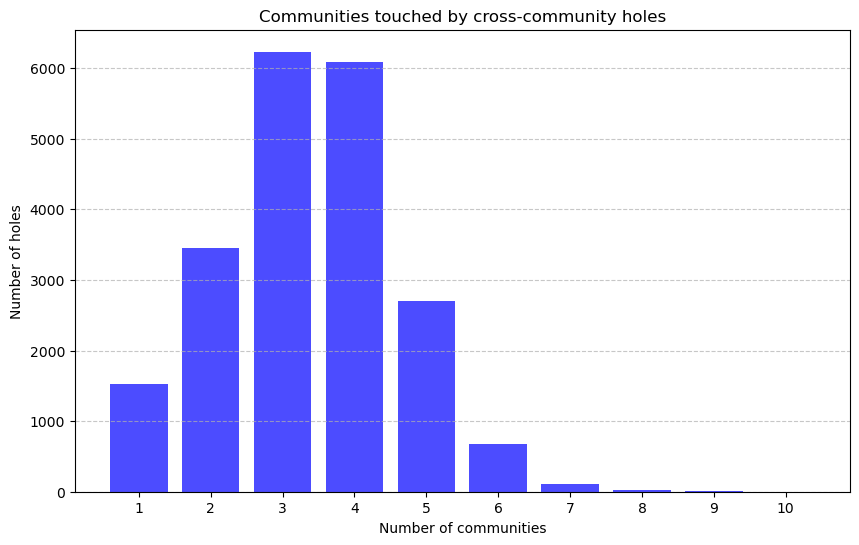

### Hypothesis testing

Are these distributions significantly (statistically) different? First, we find out if they're normal.

In [ ]:
from scipy.stats import shapiro

stat_given, p_given = shapiro(unique_coms)  # random cycles
stat_random, p_random = shapiro(result_list)  # holes

print(f'Given cycles: Statistics={stat_given}, p-value={p_given}')
print(f'Random cycles: Statistics={stat_random}, p-value={p_random}')

alpha = 0.05
if p_given > alpha and p_random > alpha:
    print('Both samples look Gaussian (fail to reject H0)')
else:
    print('At least one sample does not look Gaussian (reject H0)')

Given cycles: Statistics=0.7773835062980652, p-value=0.0
Random cycles: Statistics=0.9392277002334595, p-value=0.0
At least one sample does not look Gaussian (reject H0)


/opt/anaconda3/lib/python3.11/site-packages/scipy/stats/_morestats.py:1882: UserWarning:

p-value may not be accurate for N > 5000.



They're not, so we use a non-parametric hypothesis test.

In [ ]:
from scipy.stats import mannwhitneyu

u_stat, p_val = mannwhitneyu(result_list, unique_coms)
print(f'Mann-Whitney U Test: U-statistic={u_stat}, p-value={p_val}')

if p_val < alpha:
    print('The difference is statistically significant (reject H0)')
else:
    print('The difference is not statistically significant (fail to reject H0)')

Mann-Whitney U Test: U-statistic=346084618.0, p-value=0.0
The difference is statistically significant (reject H0)


In [ ]:
from scipy.stats import kstest  # Komogorov Smirnov

u_stat, p_val = kstest(result_list, unique_coms)
print(f'Komogorov Smirnov: Test statistic={u_stat}, p-value={p_val}')

if p_val < alpha:
    print('The difference is statistically significant (reject H0)')
else:
    print('The difference is not statistically significant (fail to reject H0)')

Komogorov Smirnov: Test statistic=0.4952907256126862, p-value=0.0
The difference is statistically significant (reject H0)


In [ ]:
from scipy.stats import ks_2samp  # Komogorov Smirnov

u_stat, p_val = ks_2samp(result_list, unique_coms)
print(f'Komogorov Smirnov: Test statistic={u_stat}, p-value={p_val}')

if p_val < alpha:
    print('The difference is statistically significant (reject H0)')
else:
    print('The difference is not statistically significant (fail to reject H0)')

Komogorov Smirnov: Test statistic=0.4952907256126862, p-value=0.0
The difference is statistically significant (reject H0)


### Hypothesis test
Null Hypothesis (H0): There is no significant difference in the number of communities intersected by the given cycles and the randomly selected cycles. This implies that any observed difference is due to random chance.

Alternative Hypothesis (H1): There is a significant difference in the number of communities intersected by the given cycles and the randomly selected cycles. This implies that the observed difference is not due to random chance and that the given cycles intersect a different number of communities compared to the random cycles.

After conducting a Mann-Whitney U Test (due to the non-normal shape of the data), we reject the null hypothesis with an alpha of .05 due to a p-value of 0.0. There is significant evidence to suggest that there is a difference in the number of communities intersected by the homological holes and the randomly selected cycles.

### Now, for a moment, lets go back to the cutoff for min random cycle length. How do the lengths of our random cycles compare to the hole lengths?

In [ ]:
hole_lengths = []
random_cycle_lengths = []
for item in big_rep_cycle_list1:
    hole_lengths.append(len(item))
for item in found_cycles:
    random_cycle_lengths.append(len(item))
print(np.mean(hole_lengths))
print(np.mean(random_cycle_lengths))

4.96006727534839
4.96006727534839


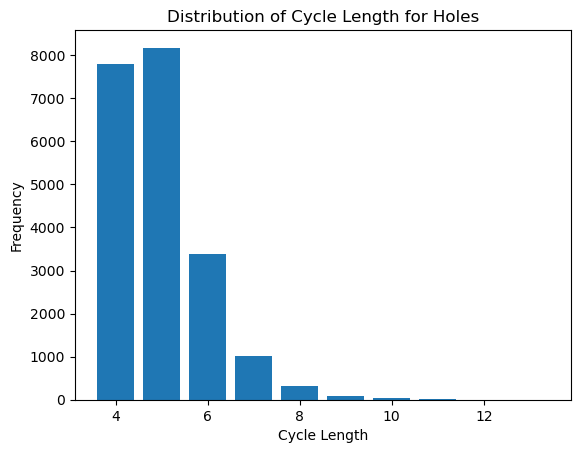

In [ ]:
from collections import Counter

frequency = Counter(hole_lengths)
keys = list(frequency.keys())
values = list(frequency.values())

plt.bar(keys, values)
plt.xlabel('Cycle Length')
plt.ylabel('Frequency')
plt.title('Distribution of Cycle Length for Holes')

plt.show()

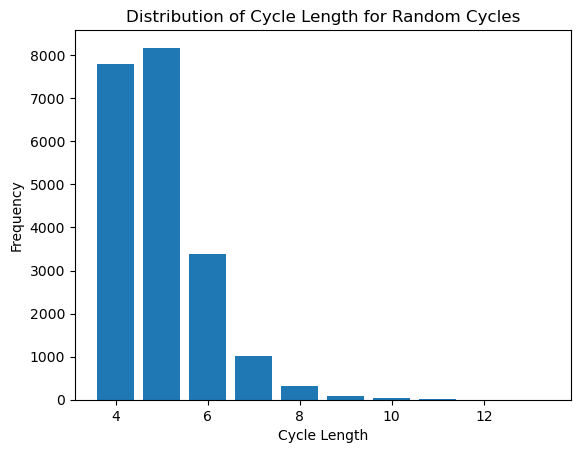

In [ ]:
from collections import Counter

frequency = Counter(random_cycle_lengths)
keys = list(frequency.keys())
values = list(frequency.values())

plt.bar(keys, values)
plt.xlabel('Cycle Length')
plt.ylabel('Frequency')
plt.title('Distribution of Cycle Length for Random Cycles')

plt.show()

## Community (and hole) Labeling Using GPT 3.5 Turbo

In [ ]:
import openai
import pandas as pd
import numpy as np
import json
import os

In [ ]:
from openai import OpenAI
OPENAI_API_KEY="INSERT KEY HERE"

client = OpenAI(
    api_key="INSERT KEY HERE",
)

chat_completion = client.chat.completions.create(
    messages=[
        {
            "role": "user",
            "content": "Say this is a test",
        }
    ],
    model="gpt-3.5-turbo",
)

In [ ]:
print(chat_completion.choices[0].message.content.strip())

This is a test.


In [ ]:
chat_completion = client.chat.completions.create(
    messages=[
        {
            "role": "user",
            "content": "I have a list of scientific concepts in the field of applied mathematics: ['interior point algorithm', 'line search', 'discrete time optimal control problem', 'unconstrained optimal control problem'] If you had to assign a label to this list that gave it a more specific overarching theme (Such as 'control theory' or 'linear algebra'), what would it be?",
        }
    ],
    model="gpt-3.5-turbo",
)
print(chat_completion.choices[0].message.content.strip())

Optimization Theory


In [ ]:
community_labels_3_5 = []
for com in coms:
    chat_completion = client.chat.completions.create(
        messages=[
            {
                "role": "user",
                "content": f"I have a list of scientific concepts in the field of applied mathematics: {list(com)} If you had to assign a label to this list that gave it a more specific overarching theme, what would it be? Only provide the label and no other text. If the list contains only one item, the label should be that item. Do not use the phrase 'applied mathematics'",
            }
        ],
        model="gpt-3.5-turbo",
    )
    community_labels_3_5.append(chat_completion.choices[0].message.content.strip())
print(community_labels_3_5)

['Control Theory', 'Financial Mathematics', 'Predictive Control Theory', 'Control Systems', 'Control Systems Theory', 'Control Systems Theory', 'Fluid dynamics', 'Optimization Theory', 'Multiagent systems', 'Traffic Flow Theory', 'Dynamical Systems.', 'Optimal Control Theory', 'Stochastic Control Theory', 'Control Systems', 'Control Systems', 'Stochastic Systems & Estimation', 'Quantum Optimal Control', 'Optimization Theory', 'heavy metal', 'Fractional Differential Equations', 'Statistical Modeling', 'Control Systems', 'Control Systems', 'Optimal Control Theory', 'Model Order Reduction', 'Public Administration', 'Mathematical research', 'Mechanical Properties', 'Control Systems', 'Dynamical Systems', 'Mathematical Modeling and Analysis', 'Formal languages', 'Artificial Intelligence and Machine Learning', 'Advanced Mathematical Concepts', 'Celestial bodies', 'Control Theory', 'Supply Chain Management', 'Thermal Physics', 'Fluid Mechanics', 'Laser physics', 'Control Theory']


In [ ]:
community_labels_3_5 = ['Control Theory', 'Financial Mathematics', 'Predictive Control Theory', 'Control Systems', 'Control Systems Theory', 'Control Systems Theory', 'Fluid dynamics', 'Optimization Theory', 'Multiagent systems', 'Traffic Flow Theory', 'Dynamical Systems.', 'Optimal Control Theory', 'Stochastic Control Theory', 'Control Systems', 'Control Systems', 'Stochastic Systems & Estimation', 'Quantum Optimal Control', 'Optimization Theory', 'heavy metal', 'Fractional Differential Equations', 'Statistical Modeling', 'Control Systems', 'Control Systems', 'Optimal Control Theory', 'Model Order Reduction', 'Public Administration', 'Mathematical research', 'Mechanical Properties', 'Control Systems', 'Dynamical Systems', 'Mathematical Modeling and Analysis', 'Formal languages', 'Artificial Intelligence and Machine Learning', 'Advanced Mathematical Concepts', 'Celestial bodies', 'Control Theory', 'Supply Chain Management', 'Thermal Physics', 'Fluid Mechanics', 'Laser physics', 'Control Theory']
print(community_labels_3_5[18])

heavy metal


In [ ]:
print(coms[18])

{'heavy metal'}


In [ ]:
combos = []
for index in range(5):
    combo = comb_keys[comb_values.index(sorted(comb_values, reverse=True)[index])]
    combos.append(combo)

combos = list(set(combos))
print(combos)

for combo in combos:
    print(f"There are {comb_values[comb_keys.index(combo)]} holes in the community combo {combo}, labeled as:")
    combo_list = combo.split(" & ")
    cs = []
    for c in combo_list:
        cs.append(community_labels_3_5[int(c)])
    print(" & ".join(cs), "\n")

['19 & 30', '10 & 33', '30 & 33', '5 & 21']
There are 100 holes in the community combo 19 & 30, labeled as:
Fractional Differential Equations & Mathematical Modeling and Analysis 

There are 102 holes in the community combo 10 & 33, labeled as:
Dynamical Systems. & Advanced Mathematical Concepts 

There are 179 holes in the community combo 30 & 33, labeled as:
Mathematical Modeling and Analysis & Advanced Mathematical Concepts 

There are 103 holes in the community combo 5 & 21, labeled as:
Control Systems Theory & Control Systems 



In [ ]:
print(categorized_holes[(19, 30)][1])

['second order elliptic partial differential equation', 'singular perturbation problem', 'set of equation', 'first order equation', 'ordinary linear differential equation', 'second order equation']


### Comparison of Methods
Let's take a random hole: 'traffic model', 'traffic network', 'traffic control', 'optimal control scheme', 'pure time delay', 'non linear problem', 'optimal control function', 'optimal open loop control'

The label generated by ChatGPT for this hole is: Optimal Control and Traffic Systems

In [ ]:
this_hole = big_rep_cycle_list1[1]
comm_numbers = {i for i in categorized_holes if this_hole in categorized_holes[i]}
print(comm_numbers)

{(13, 21, 28, 33, 35)}


In [ ]:
coms_

In [ ]:
combo_list = (13, 21, 28, 33, 35)
for c in combo_list:
    cs.append(community_labels_3_5[int(c)])
cs = list(set(cs))
print(" & ".join(cs), "\n")

Advanced Mathematical Concepts & Control Systems Theory & Control Systems & Control Theory 



Obviously our generated label is far too long. Let's try another method—something similar to zero-shot classification. ChatGPT has identified the following 25 core-concepts in the field of applied mathematics:

1. Numerical Analysis
2. Optimization
3. Probability and Statistics
4. Mathematical Physics
5. Mathematical Biology
6. Dynamical Systems
7. Control Theory
8. Game Theory
9. Operations Research
10. Computational Mathematics
11. Financial Mathematics
12. Actuarial Science
13. Cryptography
14. Information Theory
15. Signal Processing
16. Mathematical Epidemiology
17. Fluid Dynamics
18. Solid Mechanics
19. Wave Propagation
20. Graph Theory
21. Topological Data Analysis
22. Inverse Problems
23. Image Processing
24. Machine Learning
25. Stochastic Processes

### Comparison to Labels Generated by GPT4

In [ ]:
print(categorized_holes[(33, 39)][0])

['interior point algorithm', 'line search', 'discrete time optimal control problem', 'unconstrained optimal control problem']


Using our method from above, this hole is categorized as **"Optimal Control and Game Theory & Numerical Optimization Methods"**. Chat GPT 4 categorizes it as **"Optimization in Control Theory"**. When prompted to see if our generated label was acceptable, it said *"Yes, that makes sense. "Optimal Control and Game Theory & Numerical Optimization Methods" accurately encompasses the concepts you listed, as they pertain to both optimal control problems and numerical methods for solving such problems. It's a detailed and precise label that captures the interdisciplinary nature of these topics."*

Lets try a few more examples.

In [ ]:
print(categorized_holes[(21, 33)][0])

['numerical result', 'space dimension', 'finite dimensional case', 'finite dimensional problem']


In [ ]:
print(coms[1])

{'input output analysis', 'global financial crisis', 'market model', 'market efficiency', 'equilibrium model', 'input output model', 'path dependent option', 'stochastic target problem', 'extreme value theory', 'forecasting model', 'convex risk measure', 'primal dual algorithm', 'time markov chain', 'systemic risk', 'shanghai stock market', 'dynamic conditional correlation', 'option pricing', 'jump diffusion', 'exchange rate', 'price return', 'lead lag relationship', 'price level', 'oil price', 'stock price', 'discrete time framework', 'continuous time model', 'utility maximization problem', 'financial crisis', 'black scholes model', 'optimal strategy', 'deterministic optimal control problem', 'economic development', 'real financial market', 'continuous time stochastic model', 'equivalent martingale measure', 'cost benefit analysis', 'construction industry', 'finite state markov chain', 'international stock market', 'market index', 'efficiency score', 'high dimensional partial differen

Chat GPT label: **"Finite Dimensional Analysis in Numerical Methods"**

Our label: **"Numerical Methods and Optimization in Differential Equations and Control Systems & Optimal Control and Game Theory"**

Acceptable alternative?: *Your label "Numerical Methods and Optimization in Differential Equations and Control Systems & Optimal Control and Game Theory" is comprehensive and does cover the broader context of these terms. However, it might be a bit too broad for the specific concepts listed. A more concise label could be "Numerical Methods in Finite Dimensional Analysis"*

In [ ]:
print(categorized_holes[(9, 30, 33)][0])
print()


['mathematical expectation', 'one dimensional brownian motion', 'norme linear space', 'lump parameter system', 'ito stochastic differential equation', 'regulator problem']


Chat GPT label: **"Stochastic Processes and Control in Mathematical Analysis"**

Our label: **Advanced Differential Equations and Stochastic Systems & Stochastic Dynamics and Control & Optimal Control and Game Theory**

Acceptable alternative?: *Your label "Advanced Differential Equations and Stochastic Systems & Stochastic Dynamics and Control & Optimal Control and Game Theory" makes sense and is comprehensive. It accurately reflects the advanced nature of the topics, the stochastic aspects, and the control theory elements. While it is quite detailed, it does effectively cover the key areas represented by the concepts in your list.*

In [ ]:
print(categorized_holes[(9, 33)][0])

['hamilton jacobi theory', 'risk sensitive control problem', 'certainty equivalence principle', 'zero sum differential game', 'linear differential game', 'state estimate']


Chat GPT label: **"Advanced Control Theory and Differential Games"**

Our label: **"Advanced Differential Equations and Stochastic Systems & Optimal Control and Game Theory"**

Acceptable alternative?: *Your label "Advanced Differential Equations and Stochastic Systems & Optimal Control and Game Theory" makes sense and is quite comprehensive. It covers the advanced differential equations and stochastic aspects as well as the optimal control and game theory elements. While it is a broad label, it does encapsulate the key themes of the listed concepts effectively.*

### Psuedo-network
Now let's test some of these visualizations on a manufactured psuedo-network. We create 10 strongly connected graphs and then edge-swap to connect them all to eachother. This effectively creates a network with 10 communities.

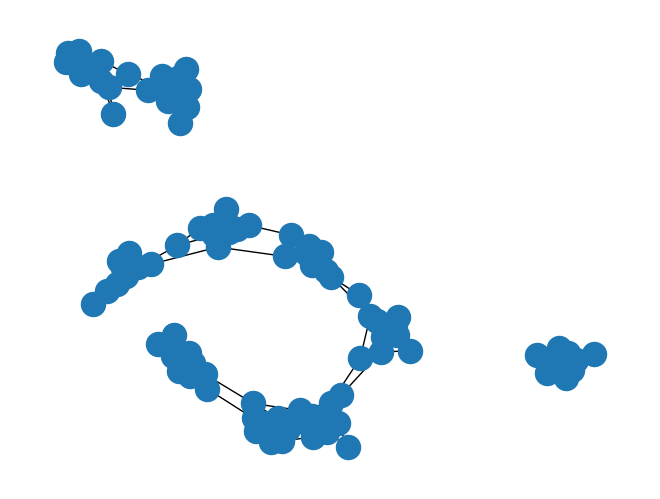

In [ ]:
n_communities = 10
n_nodes = 100
p = .5
swap_rate = .1
res = 1

nodes_per_community = [1+n_nodes//n_communities if i < n_nodes%n_communities else n_nodes//n_communities for i in range(n_communities)]
G = nx.compose_all([nx.relabel_nodes(nx.erdos_renyi_graph(n, p), lambda u: u+sum(nodes_per_community[:i])) for i, n in enumerate(nodes_per_community)])
G = nx.double_edge_swap(G, nswap=n_nodes*swap_rate, max_tries=n_nodes*swap_rate*2)
nx.draw(G)

10


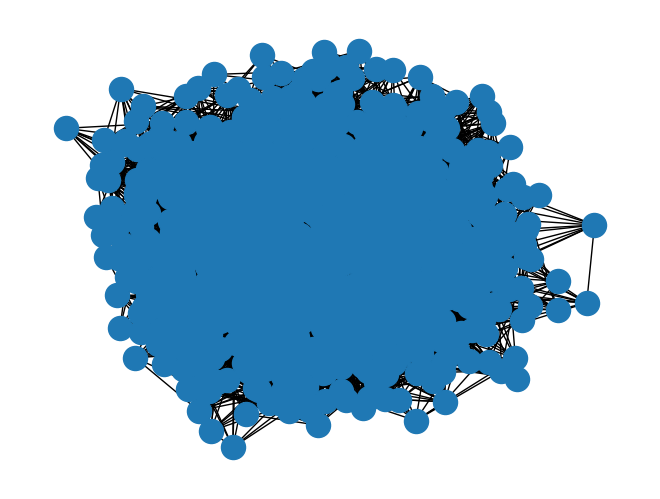

In [ ]:
n_communities = 10
n_nodes = 750
p = 0.25
swap_rate = 3
res = 1

nodes_per_community = [1+n_nodes//n_communities if i < n_nodes%n_communities else n_nodes//n_communities for i in range(n_communities)]
G = nx.compose_all([nx.relabel_nodes(nx.erdos_renyi_graph(n, p), lambda u: u+sum(nodes_per_community[:i])) for i, n in enumerate(nodes_per_community)])
G = nx.double_edge_swap(G, nswap=n_nodes*swap_rate, max_tries=n_nodes*swap_rate*2)
nx.draw(G)

coms = nx.community.louvain_communities(G, resolution=res, seed = 12)
print(len(coms))

In [ ]:
lens=[]
all_communities_list = []
for i in range(100):
    coms = nx.community.louvain_communities(G, seed=i, resolution=1)
    all_communities_list.append(coms)
    lens.append(len(coms))
print(f"average: {np.mean(lens)}")
print(f"std: {np.std(lens, ddof=1)}")

average: 9.97
std: 0.17144660799776534


In [ ]:
def flatten_communities(communities):
    node_to_community = {}
    for i, community in enumerate(communities):
        for node in community:
            node_to_community[node] = i
    return [node_to_community[node] for node in G.nodes()]
flattened_communities = [flatten_communities(communities) for communities in all_communities_list]

ari_scores = []
nmi_scores = []

for i in range(100):
    for j in range(i + 1, 100):
        ari = adjusted_rand_score(flattened_communities[i], flattened_communities[j])
        nmi = normalized_mutual_info_score(flattened_communities[i], flattened_communities[j])
        ari_scores.append(ari)
        nmi_scores.append(nmi)

In [ ]:
ari_mean = np.mean(ari_scores)
ari_std = np.std(ari_scores)

nmi_mean = np.mean(nmi_scores)
nmi_std = np.std(nmi_scores)

print(f"ARI Mean: {ari_mean}, ARI Std: {ari_std}")
print(f"NMI Mean: {nmi_mean}, NMI Std: {nmi_std}")

ARI Mean: 0.9847224239852276, ARI Std: 0.025016786297837903
NMI Mean: 0.9890866035354959, NMI Std: 0.01020866606142108


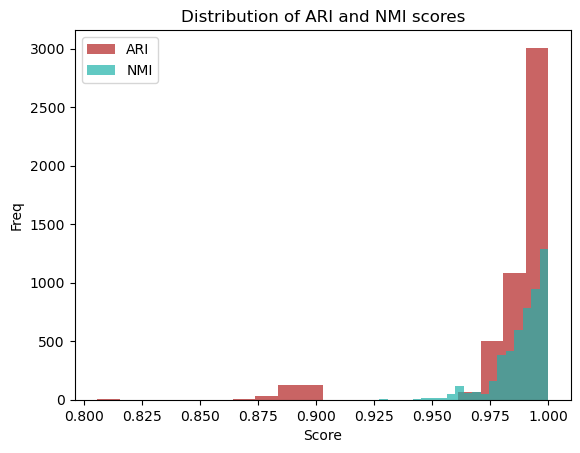

In [ ]:
plt.hist(ari_scores, bins=20, alpha=0.7, label='ARI', color="firebrick")
plt.hist(nmi_scores, bins=20, alpha=0.7, label='NMI', color="lightseagreen")
plt.xlabel('Score')
plt.ylabel('Freq')
plt.legend(loc='best')
plt.title('Distribution of ARI and NMI scores')
plt.show()

In [ ]:
nmi_means = []
ari_means = []
resolutions = []
community_sizes = []

for reso in range(10,50,2): 
    res = reso/10
    resolutions.append(res)
    all_communities_list = []
    lens = []
    for i in range(100):
        coms = nx.community.louvain_communities(G, seed=i, resolution=res)
        all_communities_list.append(coms)
        lens.append(len(coms))
    print(f"resolution: {res}")
    print(f"average communities: {np.mean(lens)}, std: {np.std(lens, ddof=1)}")
    community_sizes.append(np.mean(lens))

    def flatten_communities(communities):
        node_to_community = {}
        for i, community in enumerate(communities):
            for node in community:
                node_to_community[node] = i
        return [node_to_community[node] for node in G.nodes()]
    flattened_communities = [flatten_communities(communities) for communities in all_communities_list]

    ari_scores = []
    nmi_scores = []

    for i in range(100):
        for j in range(i + 1, 100):
            ari = adjusted_rand_score(flattened_communities[i], flattened_communities[j])
            nmi = normalized_mutual_info_score(flattened_communities[i], flattened_communities[j])
            ari_scores.append(ari)
            nmi_scores.append(nmi)

    ari_mean = np.mean(ari_scores)
    ari_std = np.std(ari_scores)
    ari_means.append(ari_mean)

    nmi_mean = np.mean(nmi_scores)
    nmi_std = np.std(nmi_scores)
    nmi_means.append(nmi_mean)

    print(f"ARI mean: {ari_mean}, ARI std: {ari_std}")
    print(f"NMI mean: {nmi_mean}, NMI std: {nmi_std}")

resolution: 1.0
average communities: 9.97, std: 0.17144660799776532
ARI mean: 0.9847224239852276, ARI std: 0.025016786297837903
NMI mean: 0.9890866035354959, NMI std: 0.01020866606142108
resolution: 1.2
average communities: 10.0, std: 0.0
ARI mean: 0.9920653558747671, ARI std: 0.0060495639108896744
NMI mean: 0.9922186559882737, NMI std: 0.005949169686927557
resolution: 1.4
average communities: 10.0, std: 0.0
ARI mean: 0.992208992932388, ARI std: 0.006534377722551498
NMI mean: 0.9924273814685031, NMI std: 0.006350715588286356
resolution: 1.6
average communities: 10.33, std: 0.4725815626252608
ARI mean: 0.990746901053703, ARI std: 0.005906719961577906
NMI mean: 0.9907294173897342, NMI std: 0.005724534737417729
resolution: 1.8
average communities: 10.5, std: 0.502518907629606
ARI mean: 0.9897675916033157, ARI std: 0.006123939302160529
NMI mean: 0.9897635519189937, NMI std: 0.006002091221803383
resolution: 2.0
average communities: 10.59, std: 0.49431107042371025
ARI mean: 0.988485790459396

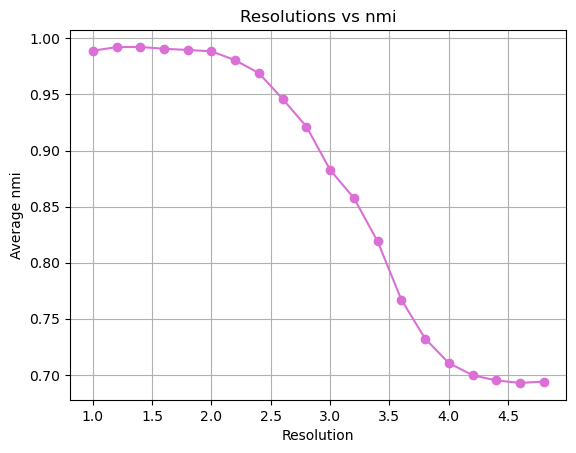

In [ ]:
plt.plot(resolutions, nmi_means, marker='o', color = "orchid")
plt.xlabel('Resolution')
plt.ylabel('Average nmi')
plt.title('Resolutions vs nmi')
plt.grid(True)
plt.show()

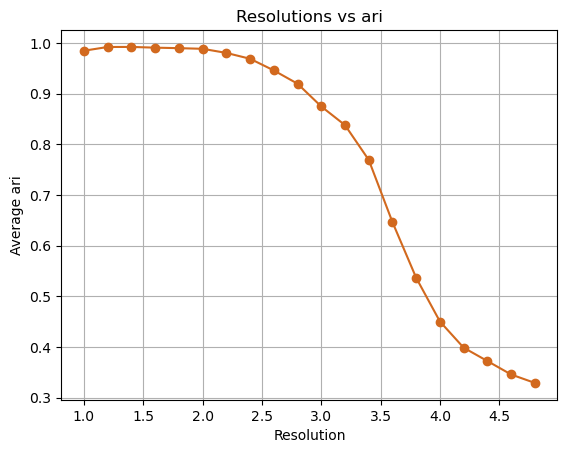

In [ ]:
plt.plot(resolutions, ari_means, marker='o', color = "chocolate")
plt.xlabel('Resolution')
plt.ylabel('Average ari')
plt.title('Resolutions vs ari')
plt.grid(True)
plt.show()

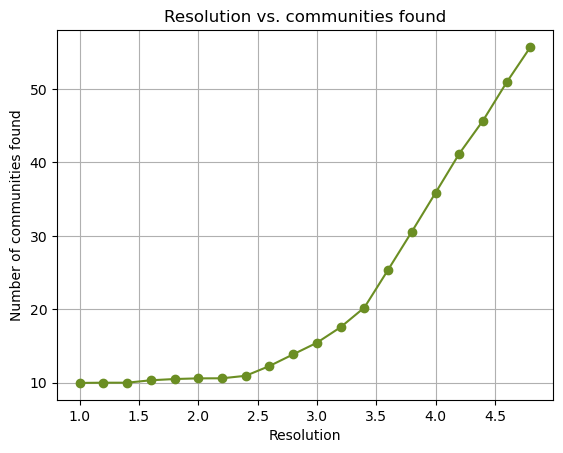

In [ ]:
plt.plot(resolutions, community_sizes, marker='o', color = "olivedrab")
plt.xlabel('Resolution')
plt.ylabel('Number of communities found')
plt.title('Resolution vs. communities found')
plt.grid(True)
plt.show()

In [ ]:
print(len(community_sizes))

2000


### Let's compare this to our plots from above (with a flitered real network)

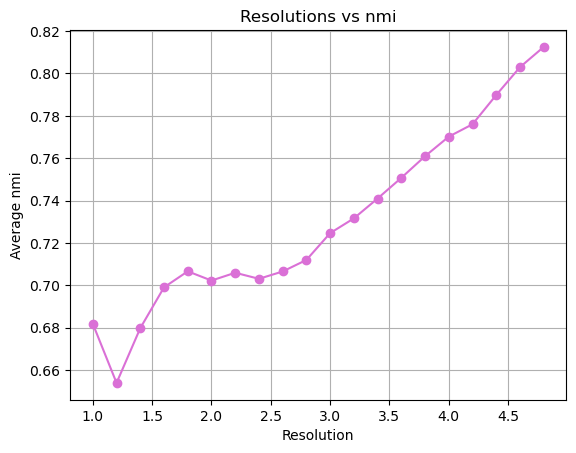

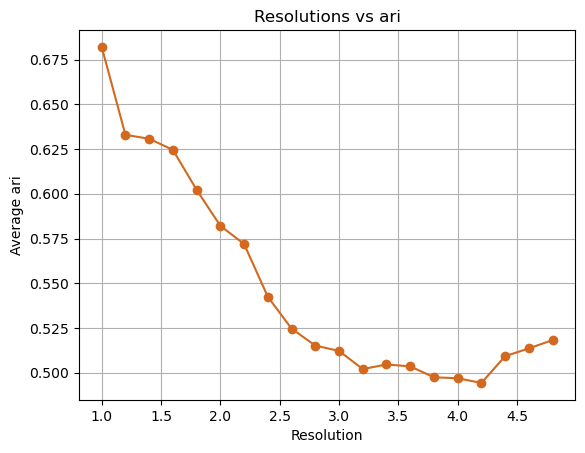

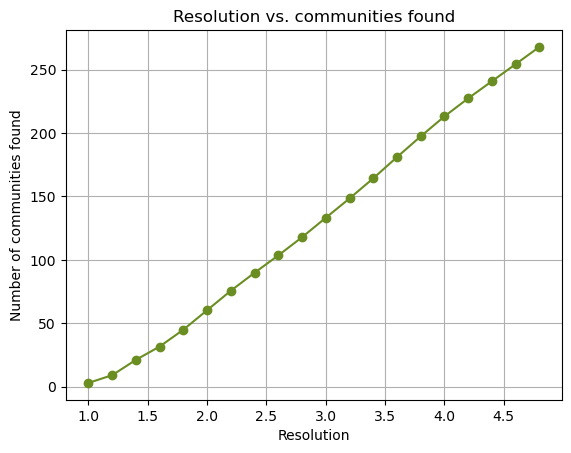

In [ ]:
plt.plot(real_resolutions, real_community_sizes, marker='o', color = "olivedrab")
plt.xlabel('Resolution')
plt.ylabel('Number of communities found')
plt.title('Resolution vs. communities found')
plt.grid(True)
plt.show()

### Interpretation of results and picking a resolution
As the resolution increases, the communities become smaller and more numerous. Higher NMI suggests that the mutual information between the clusterings is increasing, meaning that despite the higher resolution creating smaller clusters, the information shared between different runs is still high. This indicates that there is a consistent structure in the data that is being detected by the algorithm at higher resolutions. The decrease in ARI suggests that while the overall information (captured by NMI) is still high, the exact partitioning into clusters varies more at higher resolutions. This is because smaller clusters are more sensitive to small changes in the graph structure or the random initialization of the algorithm.

As for choosing a resolution, this is sorta subjective. My instinct is either 1.6 or 2.2, since we see a plateou in nmi and a large drop in ari between these values.